In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [3]:
from sklearn.tree import DecisionTreeRegressor

In [4]:
from sklearn.model_selection import GridSearchCV

In [5]:
from sklearn.metrics import mean_squared_error

# 1. Load data

In [6]:
df = pd.read_excel("online_retail_II.xlsx", sheet_name='Year 2009-2010')

In [7]:
df.shape

(525461, 8)

# 2. Check data quality

data type

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

columns name

In [12]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

data type

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


check missing value

In [16]:
df.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [17]:
df = df.dropna()

check white space

In [19]:
def empty_or_whitespace_strings(df):
    string_columns = df.select_dtypes(include=['object']).columns
    empty_whitespace_check = df[string_columns].applymap(lambda x: isinstance(x, str) and x.isspace())

    count_empty_whitespace = empty_whitespace_check.sum()
    rows_with_whitespace_indices = empty_whitespace_check.any(axis=1)
    list_row_with_whilespace_indices = df.index[rows_with_whitespace_indices].tolist()

    return count_empty_whitespace, list_row_with_whilespace_indices

In [20]:
show_whilespace, indices_whilesapce = empty_or_whitespace_strings(df)

In [21]:
show_whilespace

Invoice        0
StockCode      0
Description    0
Country        0
dtype: int64

check unique value

In [23]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  Invoice
Unique value:  [489434 489435 489436 ... 538169 538170 538171]
Count unique value:  23587
----------
Columns name:  StockCode
Unique value:  [85048 '79323P' '79323W' ... 22936 22935 22933]
Count unique value:  4031
----------
Columns name:  Description
Unique value:  ['15CM CHRISTMAS GLASS BALL 20 LIGHTS' 'PINK CHERRY LIGHTS'
 ' WHITE CHERRY LIGHTS' ... 'BAKING MOULD ROSE MILK CHOCOLATE'
 'BAKING MOULD CHOCOLATE CUP CAKES' 'BAKING MOULD EASTER EGG MILK CHOC']
Count unique value:  4459
----------
Columns name:  Quantity
Unique value:  [   12    48    24    10    18     3    16     4     2     6     8     1
    28    30    60    32    56     9    25    36    20   -12    -6    -4
   -24    -3    -2   576   288    27    64   160     5    -1    72    50
    54     7   800    11    58   192    96   144   100   180   216    15
   240   108    33    90    81   -81   -48    17    -5    40    -8    -9
    13    21   120   200   168    19   280   128  -150   -18   -23    80

check Description

In [25]:
description_counts = df.groupby('StockCode').agg(number_description=('Description', pd.Series.nunique)).reset_index()

In [26]:
multiple_descriptions = description_counts[description_counts['number_description'] > 1]

In [27]:
multiple_descriptions = multiple_descriptions.sort_values("number_description", ascending=False)

In [28]:
multiple_descriptions

,StockCode,number_description
1100,21955,4
100,20685,4
1429,22344,4
1431,22346,4
1464,22384,4
...,...,...
1295,22198,2
1294,22197,2
1293,22196,2
1292,22195,2


In [29]:
df[df['StockCode'] == 'DCGSSGIRL']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


In [30]:
df = df[~df['StockCode'].isin(multiple_descriptions['StockCode'])]

check StockCode

In [32]:
stockcode_counts = df.groupby('Description').agg(number_stockcode=('StockCode', pd.Series.nunique)).reset_index()

In [33]:
multiple_stockcode = stockcode_counts[stockcode_counts['number_stockcode'] > 1]

In [34]:
multiple_stockcode = multiple_stockcode.sort_values("number_stockcode", ascending=False)

In [35]:
multiple_stockcode

,Description,number_stockcode
1912,"METAL SIGN,CUPCAKE SINGLE HOOK",3
827,COLOURING PENCILS BROWN TUBE,3
1968,MODERN CHRISTMAS TREE CANDLE,2
3262,This is a test product.,2
3100,SQUARE CHERRY BLOSSOM CABINET,2
2631,RETRO PLASTIC POLKA TRAY,2
2629,RETRO PLASTIC DAISY TRAY,2
2628,RETRO PLASTIC 70'S TRAY,2
2316,PINK FLOWERS RABBIT EASTER,2
2307,PINK FLOCK GLASS CANDLEHOLDER,2


In [36]:
df[df['Description'] == 'damages']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


In [37]:
df = df[~df['Description'].isin(multiple_stockcode['Description'])]

check unique value (again)

In [39]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  Invoice
Unique value:  [489434 489436 489437 ... 538169 538170 538171]
Count unique value:  22626
----------
Columns name:  StockCode
Unique value:  [85048 '79323P' 22041 ... 22936 22935 22933]
Count unique value:  3563
----------
Columns name:  Description
Unique value:  ['15CM CHRISTMAS GLASS BALL 20 LIGHTS' 'PINK CHERRY LIGHTS'
 'RECORD FRAME 7" SINGLE SIZE ' ... 'BAKING MOULD ROSE WHITE CHOCOLATE'
 'BAKING MOULD ROSE MILK CHOCOLATE' 'BAKING MOULD EASTER EGG MILK CHOC']
Count unique value:  3563
----------
Columns name:  Quantity
Unique value:  [   12    48    24    18     3    16     4     2     6     8     1    28
    30    60    32    56     9    25    36    20    10   -12    -6    -4
   -24    -3    -2   576   288    64   160     5    72    -1    54     7
   800    11    58   192    96   144   180   216    15   240   108    33
   100    90    81   -81   -48    17    -5    40    -8    -9    13    21
   120    50   200   168    19   280  -150   450    27   480    46

clean Description

In [41]:
df['Description'] = df['Description'].str.replace(',', '')

In [42]:
df['Description'] = df['Description'].str.replace('*', '')

In [43]:
df['Description'] = df['Description'].str.strip()

In [44]:
for n in range(2,11,1):
    df['Description'] = df['Description'].str.replace(' '*n, '')

manual clean Description

In [46]:
df_check_description = df[['Description']].drop_duplicates()

In [47]:
def char_count(row):
    return len(set(str(row)))

In [48]:
def lowercase_count(row):
    lowercase_letters = set(char for word in row.split() for char in word if char.islower())
    return len(lowercase_letters)

In [49]:
df_check_description['Description_char_count'] = df_check_description['Description'].apply(char_count)

In [50]:
df_check_description['Description_lower_char_count'] = df_check_description['Description'].apply(lowercase_count)

In [51]:
df_check_description.to_excel('check_description.xlsx', index = False)

In [52]:
# given away
# Adjust bad debt
# Discount
# damaged
# rex use
# lost
# ?
# SAMPLES
# faulty
# Dotcom sales

In [53]:
df = df[~df['Description'].isin(['given away','Adjust bad debt','Discount','damaged','rex use','lost','?','SAMPLES','faulty','Dotcom sales'])]

export unique item name

In [55]:
# df[['Description']].drop_duplicates().to_excel('item_name_final.xlsx', index=False)

# 3. Exploratory data analysis (EDA)

In [56]:
df.sample(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
392477,527110,22380,TOY TIDY SPACEBOY,10,2010-10-14 17:23:00,2.10,14817.0,United Kingdom
214703,510192,20711,JUMBO BAG TOYS,2,2010-05-27 18:13:00,1.95,17841.0,United Kingdom
244202,513050,20799,PINK MILKSHAKE GLASS,2,2010-06-21 13:18:00,2.10,14493.0,United Kingdom
303661,519001,84212,"ASSORTED FLOWER COLOUR ""LEIS""",24,2010-08-12 18:11:00,0.65,18168.0,United Kingdom
250274,513576,21621,VINTAGE UNION JACK BUNTING,3,2010-06-25 15:24:00,8.50,16539.0,United Kingdom


Top 100 Count of Transactions by Description

In [58]:
description_counts = df['Description'].value_counts().head(100)
description_counts = description_counts.sort_values(ascending=False)

In [59]:
description_counts

Description
WHITE HANGING HEART T-LIGHT HOLDER    3245
REGENCY CAKESTAND 3 TIER              1872
STRAWBERRY CERAMIC TRINKET BOX        1536
ASSORTED COLOUR BIRD ORNAMENT         1376
HOME BUILDING BLOCK WORD              1229
                                      ... 
COLOUR GLASS. STAR T-LIGHT HOLDER      501
VINTAGE UNION JACK CUSHION COVER       490
IVORY KITCHEN SCALES                   483
WOOD BLACK BOARD ANT WHITE FINISH      482
CERAMIC STRAWBERRY CAKE MONEY BANK     481
Name: count, Length: 100, dtype: int64

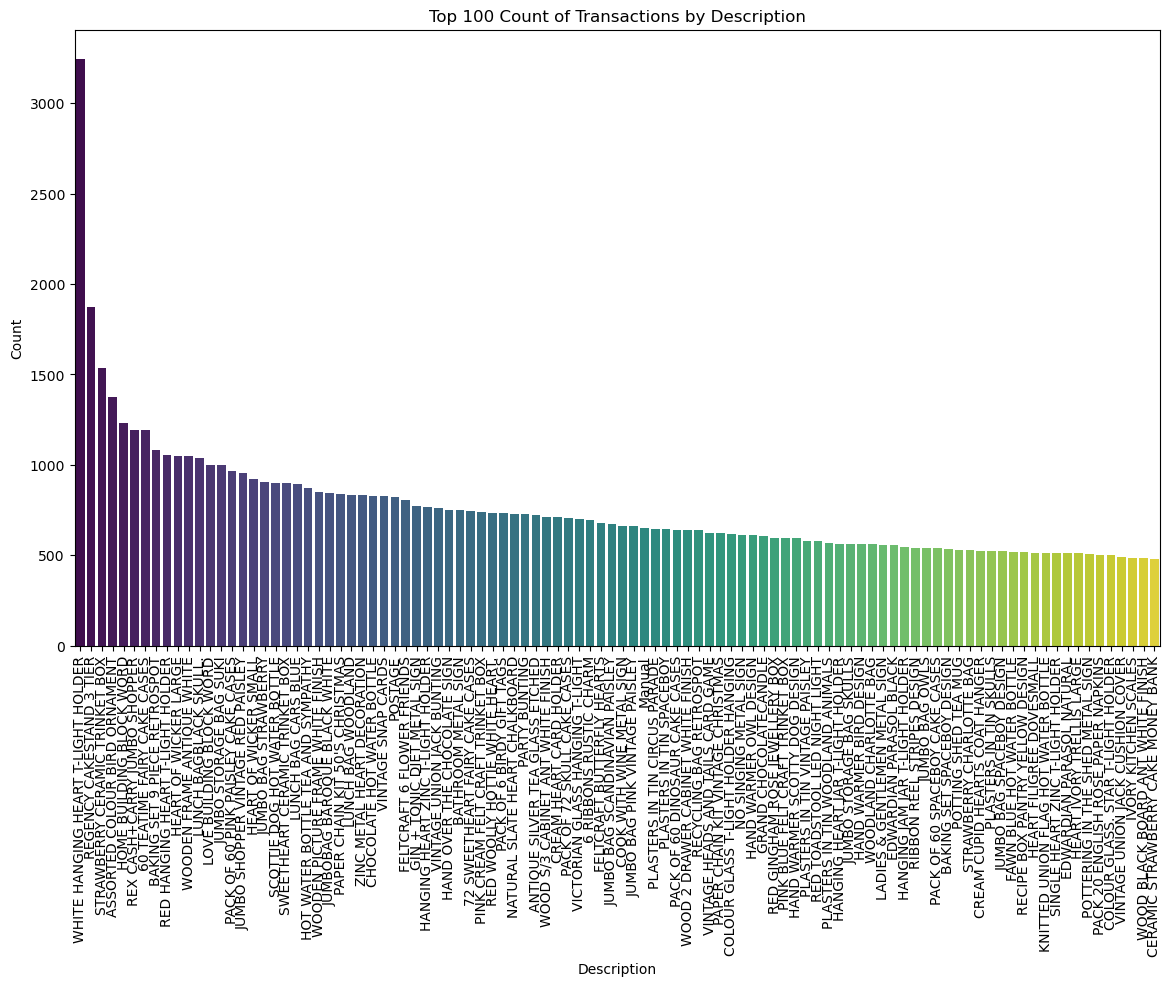

In [60]:
plt.figure(figsize=(14, 8))
sns.barplot(x=description_counts.index, y=description_counts.values, palette='viridis')
plt.title('Top 100 Count of Transactions by Description')
plt.xlabel('Description')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Top 100 Count of Transactions by Invoice

In [62]:
invoice_counts = df['Invoice'].value_counts().head(100)
invoice_counts = invoice_counts.sort_values(ascending=False)

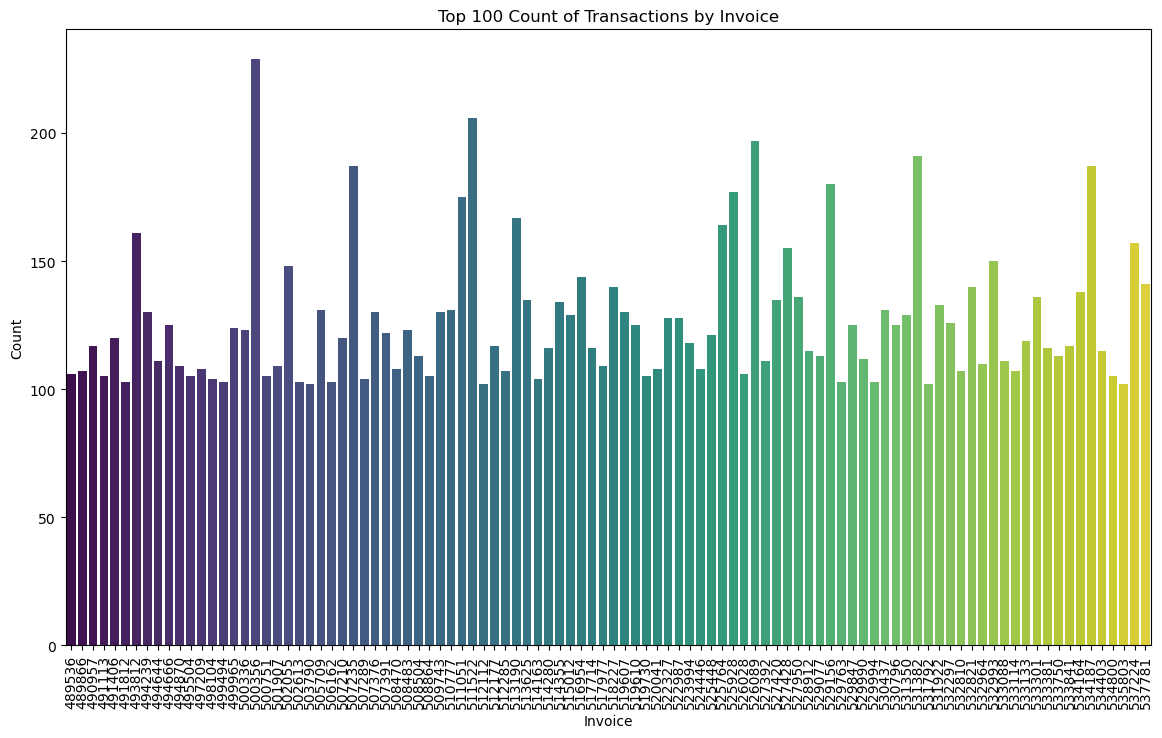

In [63]:
plt.figure(figsize=(14, 8))
sns.barplot(x=invoice_counts.index, y=invoice_counts.values, palette='viridis')
plt.title('Top 100 Count of Transactions by Invoice')
plt.xlabel('Invoice')
plt.ylabel('Count')
plt.xticks(rotation=90) 
plt.show()

# 4. Manipulate cost for optimization model

In [64]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom


In [65]:
np.random.seed(42)
df['profit_margin'] = np.random.uniform(0.01, 0.5, size=len(df))

In [66]:
df['Cost_price'] = df['Price'] * (1 - df['profit_margin'])

In [67]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,profit_margin,Cost_price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0.193525,5.605004
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0.475850,3.538012
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,0.368677,1.325778
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0.303343,0.870822
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,0.086449,1.507359


# 5. Feature engineering

In [68]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,profit_margin,Cost_price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0.193525,5.605004
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0.475850,3.538012
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,0.368677,1.325778
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0.303343,0.870822
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,0.086449,1.507359


In [69]:
df['yyyymmdd'] = df['InvoiceDate'].dt.strftime('%Y%m%d')

In [70]:
df.drop(columns='InvoiceDate', axis = 'columns')

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,profit_margin,Cost_price,yyyymmdd
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom,0.193525,5.605004,20091201
1,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom,0.475850,3.538012,20091201
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085.0,United Kingdom,0.368677,1.325778,20091201
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,United Kingdom,0.303343,0.870822,20091201
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,1.65,13085.0,United Kingdom,0.086449,1.507359,20091201
...,...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2.95,17530.0,United Kingdom,0.386707,1.809216,20101209
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,3.75,17530.0,United Kingdom,0.482346,1.941203,20101209
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,3.75,17530.0,United Kingdom,0.175825,3.090656,20101209
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,3.75,17530.0,United Kingdom,0.064746,3.507202,20101209


datetime features

In [71]:
def datetime_feature_extraction(df):
    # Day extraction
    df['dayofweek'] = df['InvoiceDate'].dt.dayofweek
    df['dayofmonth'] = df['InvoiceDate'].dt.day
    df['dayofyear'] = df['InvoiceDate'].dt.dayofyear
    df['is_weekend'] = (df['InvoiceDate'].dt.dayofweek >= 5).astype(int)
    df['weekday_weekend'] = df['InvoiceDate'].dt.dayofweek.apply(lambda x: 0 if x >= 5 else 1)

    # Week extraction
    df['weekofyear'] = df['InvoiceDate'].dt.isocalendar().week
    df['weekofmonth'] = np.ceil(df['dayofmonth'] / 7).astype(int)    
    
    # Month extraction
    df['month'] = df['InvoiceDate'].dt.month
    df['quarter'] = df['InvoiceDate'].dt.quarter
    df['days_in_month'] = df['InvoiceDate'].dt.days_in_month

    # Year extraction
    df['year'] = df['InvoiceDate'].dt.year-2009
    return df

In [72]:
df = datetime_feature_extraction(df)

group by

In [73]:
aggregation_functions = {
    'Quantity': 'sum',
    'Price': 'mean',
    'Cost_price':'mean',
    'dayofweek': 'max',
    'dayofmonth': 'max',
    'dayofyear': 'max',
    'is_weekend': 'max',
    'weekday_weekend': 'max',
    'weekofyear': 'max',
    'weekofmonth': 'max',
    'month': 'max',
    'quarter': 'max',
    'days_in_month': 'max',
    'year': 'max'
}

In [74]:
df = df.groupby(['StockCode','Description','yyyymmdd']).agg(aggregation_functions).reset_index()

In [75]:
df.head()

,StockCode,Description,yyyymmdd,Quantity,Price,Cost_price,dayofweek,dayofmonth,dayofyear,is_weekend,weekday_weekend,weekofyear,weekofmonth,month,quarter,days_in_month,year
0,10002,INFLATABLE POLITICAL GLOBE,20091201,12,0.85,0.814406,1,1,335,0,1,49,1,12,4,31,0
1,10002,INFLATABLE POLITICAL GLOBE,20091203,7,0.85,0.598676,3,3,337,0,1,49,1,12,4,31,0
2,10002,INFLATABLE POLITICAL GLOBE,20091204,73,0.85,0.614121,4,4,338,0,1,49,1,12,4,31,0
3,10002,INFLATABLE POLITICAL GLOBE,20091206,49,0.85,0.655359,6,6,340,1,0,49,1,12,4,31,0
4,10002,INFLATABLE POLITICAL GLOBE,20091207,2,0.85,0.497608,0,7,341,0,1,50,1,12,4,31,0


Create change

In [76]:
df['change_qty'] = df['Quantity'].pct_change()

In [77]:
df['change_price'] = df['Price'].pct_change()

In [78]:
df.dropna(inplace=True)

In [79]:
df.sample(10)

,StockCode,Description,yyyymmdd,Quantity,Price,Cost_price,dayofweek,dayofmonth,dayofyear,is_weekend,weekday_weekend,weekofyear,weekofmonth,month,quarter,days_in_month,year,change_qty,change_price
173869,85035C,ROSE 3 WICK MORRIS BOX CANDLE,20100622,1,4.25,4.188161,1,22,173,0,1,25,4,6,2,30,1,-1.333333,0.000000
179099,85185B,PINK HORSE SOCK PUPPET,20100714,1,2.95,2.093743,2,14,195,0,1,28,2,7,3,31,1,0.000000,0.000000
182230,90201D,GREEN ENAMEL FLOWER RING,20100623,6,2.95,2.296437,2,23,174,0,1,25,4,6,2,30,1,0.000000,0.000000
5268,20726,LUNCH BAG WOODLAND,20100211,35,1.65,1.117693,3,11,42,0,1,6,2,2,1,28,1,2.500000,0.000000
95565,22398,MAGNETS PACK OF 4 SWALLOWS,20101130,12,1.25,1.176555,1,30,334,0,1,48,5,11,4,30,1,0.000000,0.000000
6234,20733,GOLD MINI TAPE MEASURE,20100916,2,0.85,0.501580,3,16,259,0,1,37,3,9,3,30,1,0.000000,0.000000
639,15039,SANDALWOOD FAN,20100127,3,0.85,0.742034,2,27,27,0,1,4,4,1,1,31,1,2.000000,0.000000
141445,84821,DANISH ROSE DELUXE COASTER,20100512,12,0.85,0.650699,2,12,132,0,1,19,2,5,2,31,1,0.000000,0.000000
153435,16161P,WRAP ENGLISH ROSE,20100530,50,0.42,0.237190,6,30,150,1,0,21,5,5,2,31,1,0.000000,0.000000
37142,21488,RED WHITE SCARFHOT WATER BOTTLE,20101107,16,3.95,3.140115,6,7,311,1,0,44,1,11,4,30,1,-0.724138,0.067568


# 5. Get current price

In [80]:
df.sort_values(by=['Description', 'yyyymmdd'], ascending=[True, False], inplace=True)

In [81]:
df['row_number'] = df.groupby('Description').cumcount() + 1

In [82]:
df.head()

,StockCode,Description,yyyymmdd,Quantity,Price,Cost_price,dayofweek,dayofmonth,dayofyear,is_weekend,weekday_weekend,weekofyear,weekofmonth,month,quarter,days_in_month,year,change_qty,change_price,row_number
98453,22436,12 COLOURED PARTY BALLOONS,20101209,20,0.65,0.613766,3,9,343,0,1,49,2,12,4,31,1,0.666667,0.0,1
98452,22436,12 COLOURED PARTY BALLOONS,20101206,12,0.65,0.478140,0,6,340,0,1,49,1,12,4,31,1,1.000000,0.0,2
98451,22436,12 COLOURED PARTY BALLOONS,20101205,6,0.65,0.630305,6,5,339,1,0,48,1,12,4,31,1,-0.400000,0.0,3
98450,22436,12 COLOURED PARTY BALLOONS,20101202,10,0.65,0.602487,3,2,336,0,1,48,1,12,4,31,1,-0.500000,0.0,4
98449,22436,12 COLOURED PARTY BALLOONS,20101129,20,0.65,0.523991,0,29,333,0,1,48,5,11,4,30,1,-0.130435,0.0,5


lastest price

In [84]:
df_price = df[df['row_number'] == 1][['yyyymmdd','StockCode','Description','Price','Cost_price','Quantity']]

In [85]:
df_price.head()

,yyyymmdd,StockCode,Description,Price,Cost_price,Quantity
98453,20101209,22436,12 COLOURED PARTY BALLOONS,0.65,0.613766,20
34689,20101201,21448,12 DAISY PEGS IN WOOD BOX,1.65,1.221647,8
88505,20101129,22282,12 EGG HOUSE PAINTED WOOD,12.75,10.993110,2
34595,20101206,21447,12 IVORY ROSE PEG PLACE SETTINGS,1.25,0.971906,12
123503,20101209,22906,12 MESSAGE CARDS WITH ENVELOPES,1.65,0.912191,31


# 6. Model

In [86]:
df.head()

,StockCode,Description,yyyymmdd,Quantity,Price,Cost_price,dayofweek,dayofmonth,dayofyear,is_weekend,weekday_weekend,weekofyear,weekofmonth,month,quarter,days_in_month,year,change_qty,change_price,row_number
98453,22436,12 COLOURED PARTY BALLOONS,20101209,20,0.65,0.613766,3,9,343,0,1,49,2,12,4,31,1,0.666667,0.0,1
98452,22436,12 COLOURED PARTY BALLOONS,20101206,12,0.65,0.478140,0,6,340,0,1,49,1,12,4,31,1,1.000000,0.0,2
98451,22436,12 COLOURED PARTY BALLOONS,20101205,6,0.65,0.630305,6,5,339,1,0,48,1,12,4,31,1,-0.400000,0.0,3
98450,22436,12 COLOURED PARTY BALLOONS,20101202,10,0.65,0.602487,3,2,336,0,1,48,1,12,4,31,1,-0.500000,0.0,4
98449,22436,12 COLOURED PARTY BALLOONS,20101129,20,0.65,0.523991,0,29,333,0,1,48,5,11,4,30,1,-0.130435,0.0,5


create 1 model each SKU

In [88]:
df_sku = df[df['Description'] == 'REGENCY CAKESTAND 3 TIER']

In [89]:
df_sku.drop(columns=['StockCode','Description','yyyymmdd','Quantity','Price','Cost_price','row_number'], axis='columns', inplace=True)

In [90]:
df_sku

,dayofweek,dayofmonth,dayofyear,is_weekend,weekday_weekend,weekofyear,weekofmonth,month,quarter,days_in_month,year,change_qty,change_price
97392,3,9,343,0,1,49,2,12,4,31,1,0.510204,-0.020183
97391,2,8,342,0,1,49,2,12,4,31,1,-0.494845,-0.003233
97390,1,7,341,0,1,49,1,12,4,31,1,1.309524,-0.040336
97389,0,6,340,0,1,49,1,12,4,31,1,-0.543478,0.044226
97388,6,5,339,1,0,48,1,12,4,31,1,-0.394737,-0.002102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97180,4,19,78,0,1,11,3,3,1,31,1,1.904762,-0.015686
97179,3,18,77,0,1,11,3,3,1,31,1,0.000000,0.000000
97178,2,17,76,0,1,11,3,3,1,31,1,-0.461538,0.017964
97177,1,16,75,0,1,11,3,3,1,31,1,3.875000,-0.017647


split X and y

In [92]:
X = df_sku.drop(columns=['change_qty'])
y = df_sku['change_qty']

model training

In [94]:
rt = DecisionTreeRegressor(random_state=42)

In [95]:
param_grid = {
    'max_depth': [None, 2, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10]
}

In [96]:
grid_search = GridSearchCV(estimator=rt, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

In [97]:
grid_search.fit(X, y)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15]},
             scoring='neg_mean_squared_error', verbose=2)

In [98]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=2, min_samples_leaf=5, random_state=42)

In [99]:
grid_search.best_score_

-14.42243621184061

save model

In [101]:
best_model = grid_search.best_estimator_

# 7. Optimize

random point of time

In [103]:
df_sku_optimize = df_sku[['dayofweek','dayofmonth','dayofyear','is_weekend','weekday_weekend','weekofyear','weekofmonth','month','quarter','days_in_month','year']].sample(1)

In [104]:
multipliers = [round(x * 0.01, 2) for x in range(-50, 51)]

In [105]:
df_sku_optimize = df_sku_optimize.loc[np.repeat(df_sku_optimize.index.values, len(multipliers))]

In [106]:
df_sku_optimize['change_price'] = multipliers

In [107]:
df_sku_optimize.head()

,dayofweek,dayofmonth,dayofyear,is_weekend,weekday_weekend,weekofyear,weekofmonth,month,quarter,days_in_month,year,change_price
97341,0,11,284,0,1,41,2,10,4,31,1,-0.50
97341,0,11,284,0,1,41,2,10,4,31,1,-0.49
97341,0,11,284,0,1,41,2,10,4,31,1,-0.48
97341,0,11,284,0,1,41,2,10,4,31,1,-0.47
97341,0,11,284,0,1,41,2,10,4,31,1,-0.46


optimize

In [109]:
change_price_list = []

In [110]:
for i in range(df_sku_optimize.shape[0]):
    demand_change = best_model.predict(df_sku_optimize.iloc[[i]])
    change_price_list.append(demand_change[0])

In [111]:
df_sku_optimize['change_qty'] = change_price_list

In [112]:
initial_price = df_price[df_price['Description'] == 'REGENCY CAKESTAND 3 TIER']['Price'].iloc[0]
initial_cost_price = df_price[df_price['Description'] == 'REGENCY CAKESTAND 3 TIER']['Cost_price'].iloc[0]
initial_quantity = df_price[df_price['Description'] == 'REGENCY CAKESTAND 3 TIER']['Quantity'].iloc[0]

In [113]:
initial_price

11.95

In [114]:
df_sku_optimize['price_new'] = initial_price*(1+df_sku_optimize['change_price'])

In [115]:
df_sku_optimize['qty_new'] = initial_quantity*(1+df_sku_optimize['change_qty'])

In [116]:
df_sku_optimize['additional_profit'] = df_sku_optimize['qty_new']*(df_sku_optimize['price_new']-initial_cost_price)

In [117]:
df_sku_optimize.head()

,dayofweek,dayofmonth,dayofyear,is_weekend,weekday_weekend,weekofyear,weekofmonth,month,quarter,days_in_month,year,change_price,change_qty,price_new,qty_new,additional_profit
97341,0,11,284,0,1,41,2,10,4,31,1,-0.50,7.324762,5.9750,616.032381,-1013.866921
97341,0,11,284,0,1,41,2,10,4,31,1,-0.49,7.324762,6.0945,616.032381,-940.251052
97341,0,11,284,0,1,41,2,10,4,31,1,-0.48,7.324762,6.2140,616.032381,-866.635182
97341,0,11,284,0,1,41,2,10,4,31,1,-0.47,7.324762,6.3335,616.032381,-793.019313
97341,0,11,284,0,1,41,2,10,4,31,1,-0.46,7.324762,6.4530,616.032381,-719.403443


select max additional profit

In [119]:
df_sku_optimize[df_sku_optimize['additional_profit'] == df_sku_optimize['additional_profit'].max()]

,dayofweek,dayofmonth,dayofyear,is_weekend,weekday_weekend,weekofyear,weekofmonth,month,quarter,days_in_month,year,change_price,change_qty,price_new,qty_new,additional_profit
97341,0,11,284,0,1,41,2,10,4,31,1,-0.09,7.324762,10.8745,616.032381,2004.383729
